<a href="https://colab.research.google.com/github/Dayeon-Merry/Homework/blob/master/230620_%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 팀과제 (github에 개개인이 올리기)
* 전이 학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/c/dogs-vs-cats

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else'cpu'
print(device)

cuda


In [3]:
os.environ['KAGGLE_USERNAME'] = 'dayeon93' # username
os.environ['KAGGLE_KEY'] = '926faf87a266490168834d12899643da' # key

In [4]:
!kaggle datasets download -d tongpython/cat-and-dog # url에서 긁어오기
!unzip -q cat-and-dog.zip

 95% 208M/218M [00:01<00:00, 201MB/s]
100% 218M/218M [00:01<00:00, 154MB/s]


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor() # 이미지를 tensor로 바꿔라.
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [7]:
def target_transforms(target):
  return torch.FloatTensor([target])

In [8]:
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('/content/test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


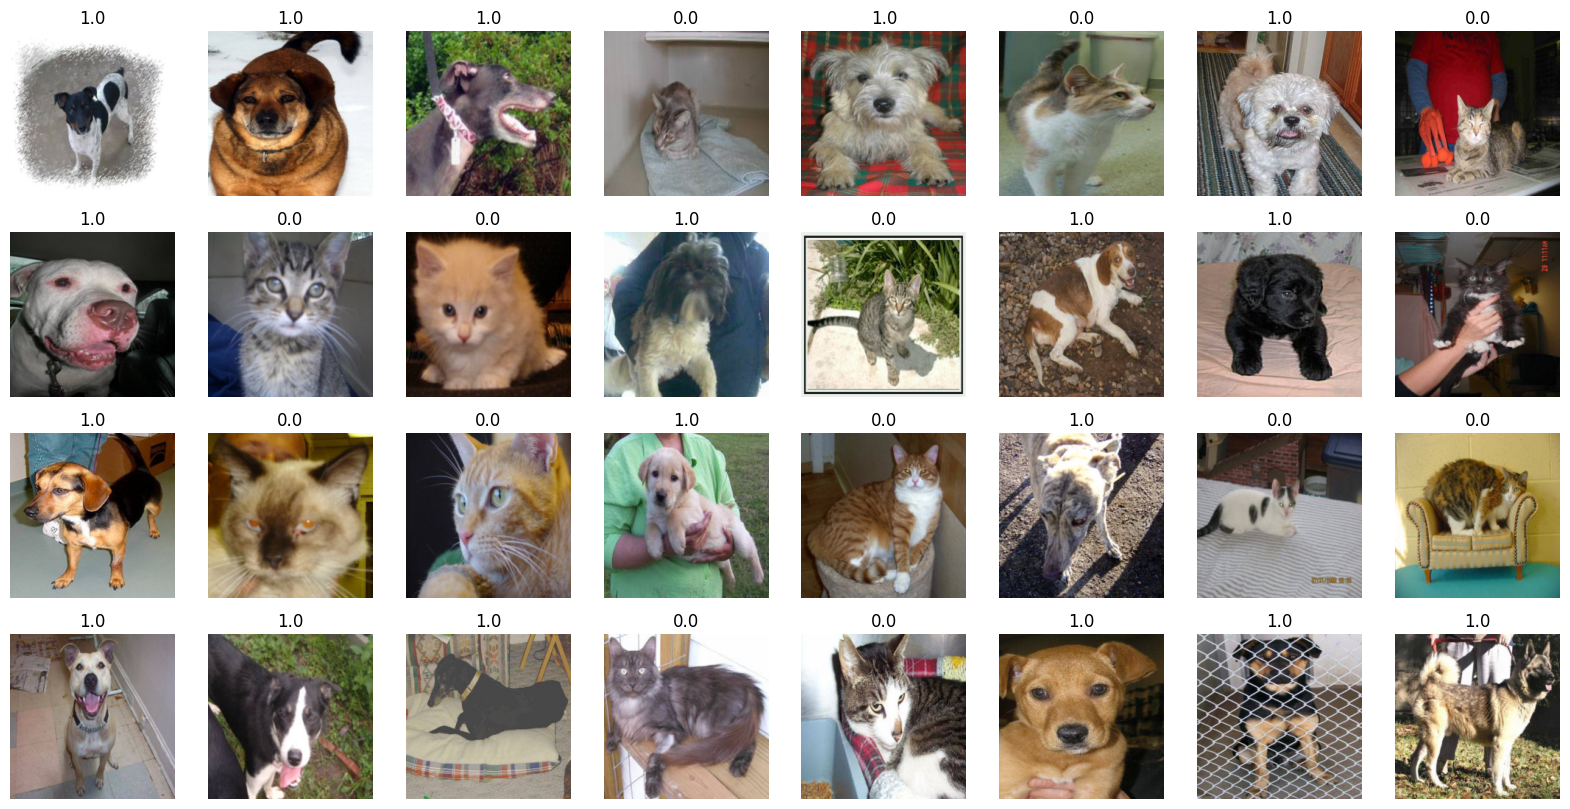

In [9]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
  ax.set_title(label.item())
  ax.imshow(img.permute(1,2,0)) # permute: 인덱스(차원)의 순서바꾸는것.
  ax.axis('off')


In [10]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 22.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(weight, bias)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128), # CNN 에서 FC로 넘길때 데이터 수가 2048개라서.
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
  for phase in ['train', 'validation']:
    if phase == 'train':
      model.train() # 메모리에 할당하여 학습모드로 optimizer를 돌리게 됨
    else:
      model.eval() # optimizer돌리는 메모리를 제거. 실제 test만 할 수 있게 train 메모리를 다 삭제시킴. 속도를 빠르게 test할 수 있음

    sum_losses = 0
    sum_accs = 0
    for x_batch, y_batch in dataloaders[phase]:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(x_batch)

        loss = nn.BCELoss()(y_pred, y_batch)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        sum_losses = sum_losses + loss.item()

        y_bool = (y_pred >= 0.5).float()
        acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc.item()

    avg_loss = sum_losses / len(dataloaders[phase])
    avg_acc = sum_accs / len(dataloaders[phase])

    print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/3, Loss: 0.1268, Accuracy: 95.28%
validation: Epoch    1/3, Loss: 0.0449, Accuracy: 98.34%
train     : Epoch    2/3, Loss: 0.0853, Accuracy: 96.71%
validation: Epoch    2/3, Loss: 0.0388, Accuracy: 98.78%
train     : Epoch    3/3, Loss: 0.0628, Accuracy: 97.52%
validation: Epoch    3/3, Loss: 0.0872, Accuracy: 96.83%


In [14]:
torch.save(model.state_dict(), 'model.h5')

In [16]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

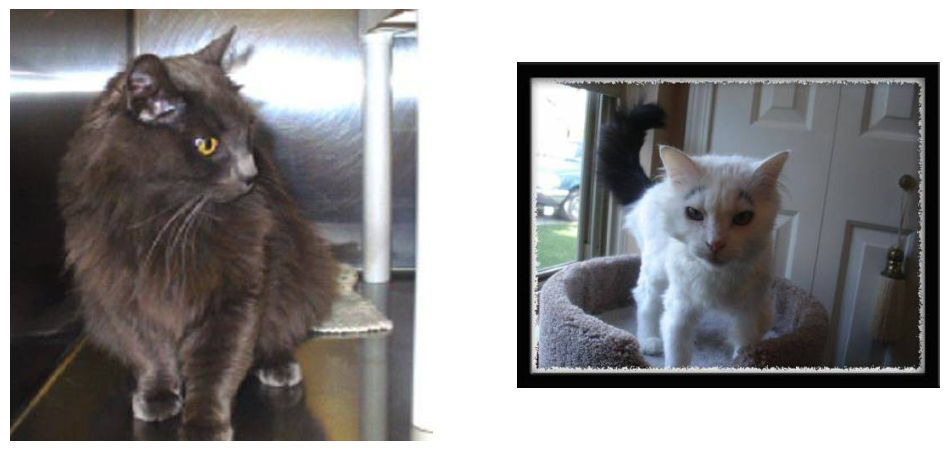

In [52]:
# 테스트
from PIL import Image

img1 = Image.open('/content/test_set/test_set/cats/cat.4286.jpg')
img2 = Image.open('/content/test_set/test_set/cats/cat.4295.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [53]:
img1_input = data_transforms['validation'](img1)
# 딕셔너리의 키를 불러와서 img1을 통과시키겠다는 의미.
# 'validation'이라는 키의 value값에 img1을 넣어는건데, value값 안에 변환함수가 들어가있기 때문에 img1이 변환된다.
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [54]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [55]:
y_pred = model(test_batch)
y_pred

tensor([[1.1488e-06],
        [2.3560e-03]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
9.7666e-05

9.7666e-05

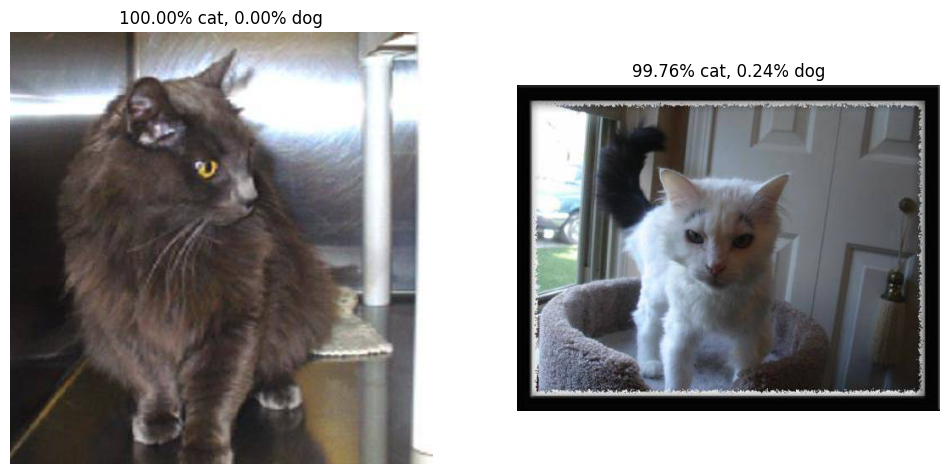

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{(1-y_pred[0,0])*100:.2f}% cat, {y_pred[0,0]*100:.2f}% dog')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1,0])*100:.2f}% cat, {y_pred[1,0]*100:.2f}% dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()